In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
import pandas as pd


In [34]:
data = load_iris()

In [35]:
# Generate synthetic dataset
# X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, 
#                          n_redundant=5, n_classes=3, random_state=42)

X = data.data
y = data.target

In [36]:
X,y

(array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
        [5

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [38]:
class ANN(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], num_classes)
        self.relu = nn.ReLU()    
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [39]:
verified_model = ANN(input_size=4, hidden_sizes=[64, 32], num_classes=3)

In [40]:
# Save initial weights
initial_weights = {}
for name, param in verified_model.named_parameters():
    initial_weights[name] = param.data.clone()

print("Initial weights saved!")
print("Weight names:", list(initial_weights.keys()))

Initial weights saved!
Weight names: ['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias']


In [41]:
# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(verified_model.parameters(), lr=0.001)

In [42]:
# Store gradients during training
all_gradients = {name: [] for name, _ in verified_model.named_parameters()}

In [43]:
# Training loop with gradient collection
epochs = 30
for epoch in range(epochs):
    verified_model.train()
    train_loss = 0.0
    epoch_gradients = {name: [] for name, _ in verified_model.named_parameters()}
    
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = verified_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        
        # Store gradients before optimizer step
        for name, param in verified_model.named_parameters():
            if param.grad is not None:
                epoch_gradients[name].append(param.grad.data.clone())
        
        optimizer.step()
        train_loss += loss.item()
    
    # Average gradients for the epoch
    for name in epoch_gradients:
        if epoch_gradients[name]:
            avg_grad = torch.stack(epoch_gradients[name]).mean(dim=0)
            all_gradients[name].append(avg_grad)
    
    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {train_loss/len(train_loader):.4f}')

Epoch [5/30], Loss: 0.8679
Epoch [10/30], Loss: 0.6365
Epoch [15/30], Loss: 0.4506
Epoch [20/30], Loss: 0.3224
Epoch [25/30], Loss: 0.2441
Epoch [30/30], Loss: 0.1886


In [ ]:
# Save trained weights
trained_weights = {}
for name, param in verified_model.named_parameters():
    trained_weights[name] = param.data.clone()



Trained weights saved!


In [ ]:
# Evaluation
verified_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = verified_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test Accuracy: {100 * correct / total:.2f}%')

verified_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in train_loader:
        outputs = verified_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()


Test Accuracy: 100.00%
Train Accuracy: 95.83%


In [46]:
reverse_model = ANN(input_size=4, hidden_sizes=[64, 32], num_classes=3)

In [47]:
# Load trained weights into reverse model
for name, param in reverse_model.named_parameters():
    param.data = trained_weights[name].clone()


In [48]:
# Verify reverse model has trained weights
print("\nVerifying reverse model has trained weights...")
for name, param in reverse_model.named_parameters():
    diff = torch.abs(param.data - trained_weights[name]).max().item()
    print(f"{name}: max difference = {diff}")


Verifying reverse model has trained weights...
fc1.weight: max difference = 0.0
fc1.bias: max difference = 0.0
fc2.weight: max difference = 0.0
fc2.bias: max difference = 0.0
fc3.weight: max difference = 0.0
fc3.bias: max difference = 0.0


In [ ]:
# Apply reverse gradient descent
learning_rate = 0.001  
for epoch in reversed(range(epochs)):
    # Get gradients for this epoch (in reverse order)
    for name, param in reverse_model.named_parameters():
        if epoch < len(all_gradients[name]):
            # Apply negative gradient (reverse direction)
            grad = all_gradients[name][epoch]
            param.data -= learning_rate * grad  #minus because we going backwards



Reverse gradient descent completed!



Comparing reversed weights with initial weights
fc1.weight:
  Max difference: 0.128142
  Mean difference: 0.068203
fc1.bias:
  Max difference: 0.135451
  Mean difference: 0.075556
fc2.weight:
  Max difference: 0.139203
  Mean difference: 0.043468
fc2.bias:
  Max difference: 0.102118
  Mean difference: 0.043764
fc3.weight:
  Max difference: 0.132350
  Mean difference: 0.056631
fc3.bias:
  Max difference: 0.015287
  Mean difference: 0.010952

All weights within tolerance (0.001)? False


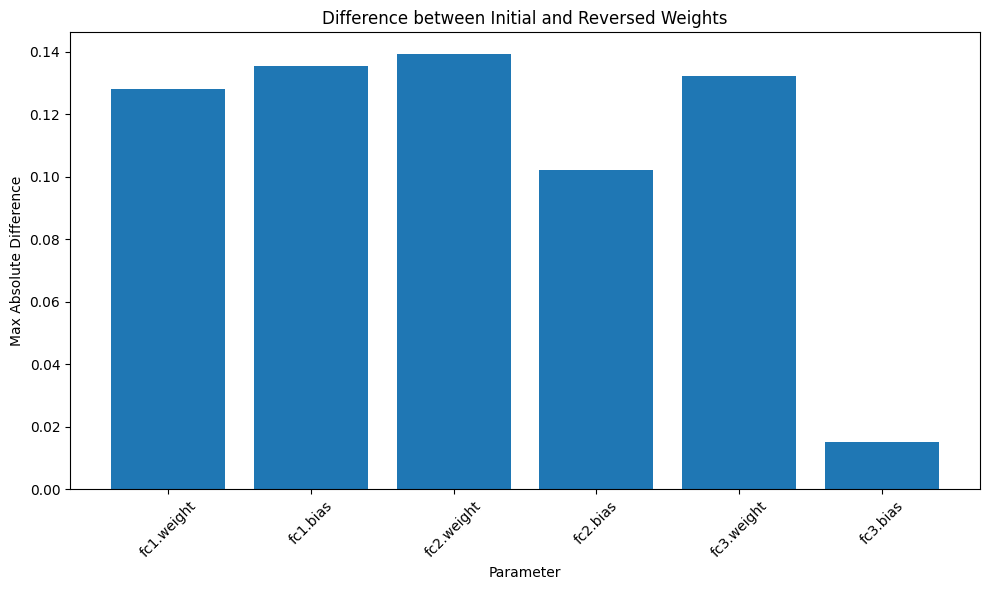

In [50]:
# Compare with initial weights
print("\n" + "="*50)
print("Comparing reversed weights with initial weights")
print("="*50)

max_differences = {}
for name, param in reverse_model.named_parameters():
    diff = torch.abs(param.data - initial_weights[name])
    max_diff = diff.max().item()
    mean_diff = diff.mean().item()
    max_differences[name] = max_diff
    print(f"{name}:")
    print(f"  Max difference: {max_diff:.6f}")
    print(f"  Mean difference: {mean_diff:.6f}")

# Check if weights are approximately equal
tolerance = 1e-3
all_close = all(diff < tolerance for diff in max_differences.values())
print(f"\nAll weights within tolerance ({tolerance})? {all_close}")

# Visualize the differences
plt.figure(figsize=(10, 6))
names = list(max_differences.keys())
differences = list(max_differences.values())
plt.bar(names, differences)
plt.xlabel('Parameter')
plt.ylabel('Max Absolute Difference')
plt.title('Difference between Initial and Reversed Weights')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
def reverse_gradient_descent(model, target_weights, gradients, lr=0.001, epochs=30):

    reverse_model = ANN(input_size=4, hidden_sizes=[64, 32], num_classes=3)
    
    for name, param in reverse_model.named_parameters():
        param.data = target_weights[name].clone()
    
    for epoch in reversed(range(epochs)):
        for name, param in reverse_model.named_parameters():
            if epoch < len(gradients[name]):
                grad = gradients[name][epoch]
                param.data -= lr * grad
    
    
    reversed_weights = {}
    for name, param in reverse_model.named_parameters():
        reversed_weights[name] = param.data.clone()
    
    return reversed_weights